A journey to figure out wtf is going on why doesn't it train

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from models import MLP, MovementPredictor
from train import get_data
from util.data import ROIS  # Custom set of ROIs we're trying to model
from util.misc import grad_norm, set_seed

In [2]:
%matplotlib inline

In [3]:
tr_dataset, ts_dataset = get_data()

Loading cached data from /scratch/users/akashc/misc_proj/cs339n/final/connectx-decoding/data/raw_data.pkl
Recording ee8b36de-779f-4dea-901f-e0141c95722b: 551 trials, T=120
(551, 120) (551,)
(551, 120) (551,)
(551, 120) (551,)
(551, 120) (551,)
eid='ee8b36de-779f-4dea-901f-e0141c95722b' all_inputs[-1].shape=(551, 4, 120)
Recording 81a78eac-9d36-4f90-a73a-7eb3ad7f770b: 1103 trials, T=120
(1103, 120) (1103,)
(1103, 120) (1103,)
(1103, 120) (1103,)
(1103, 120) (1103,)
eid='81a78eac-9d36-4f90-a73a-7eb3ad7f770b' all_inputs[-1].shape=(1103, 4, 120)
Recording 88d24c31-52e4-49cc-9f32-6adbeb9eba87: 545 trials, T=120
(545, 120) (545,)
(545, 120) (545,)
(545, 120) (545,)
(545, 120) (545,)
eid='88d24c31-52e4-49cc-9f32-6adbeb9eba87' all_inputs[-1].shape=(545, 4, 120)
(2199, 4, 120) (2199, 4)
Num blank trials:  0


In [4]:
one_x, one_y = tr_dataset[0]

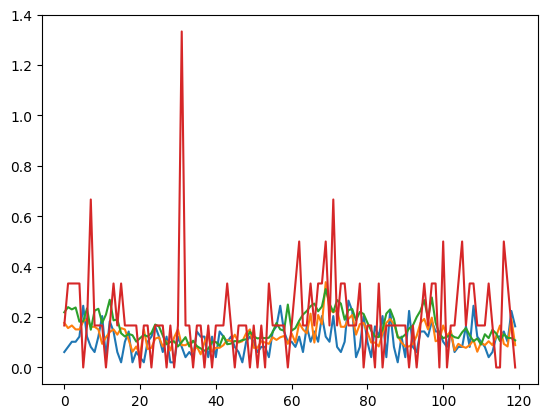

In [5]:
plt.plot(one_x.T)

In [6]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [12]:
mdl = MLP(3, np.prod(one_x.shape), 32, 1).to(device)

In [11]:
x_torch, y_torch = torch.tensor(one_x).to(device).float()[None, ...], torch.tensor(one_y).to(device).float()[None, None, ...]
y_torch.masked_fill_(y_torch < 0, 0)

tensor([[0.]], device='cuda:0')

In [13]:
optimizer = torch.optim.SGD(mdl.parameters(), lr=3e-1)

In [14]:
for i in tqdm(range(100)):
    optimizer.zero_grad()
    logit = mdl(x_torch.flatten(1))
    loss = F.binary_cross_entropy_with_logits(logit, y_torch)
    loss.backward()
    
    gnorm = grad_norm(mdl)

    optimizer.step()
    
    print(f"{i}: Loss {loss.item()}\tGrad norm {gnorm.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

0: Loss 0.7659216523170471	Grad norm 0.5751697421073914
1: Loss 0.6710473299026489	Grad norm 0.5248196721076965
2: Loss 0.5919579267501831	Grad norm 0.48012983798980713
3: Loss 0.5256728529930115	Grad norm 0.44053003191947937
4: Loss 0.4697865843772888	Grad norm 0.40547943115234375
5: Loss 0.42236462235450745	Grad norm 0.3744530975818634
6: Loss 0.3818570673465729	Grad norm 0.34695741534233093
7: Loss 0.34702444076538086	Grad norm 0.32254236936569214
8: Loss 0.31687477231025696	Grad norm 0.3008062541484833
9: Loss 0.29061248898506165	Grad norm 0.2813962996006012
10: Loss 0.26759737730026245	Grad norm 0.2640065550804138
11: Loss 0.24731165170669556	Grad norm 0.24837301671504974
12: Loss 0.2293361872434616	Grad norm 0.23425443470478058
13: Loss 0.21332569420337677	Grad norm 0.22148877382278442
14: Loss 0.19899675250053406	Grad norm 0.20989234745502472
15: Loss 0.18611547350883484	Grad norm 0.19932276010513306
16: Loss 0.1744876503944397	Grad norm 0.1896577924489975
17: Loss 0.16395062208

In [15]:
model = MovementPredictor(num_regions=len(ROIS)).to(device)
new_optimizer = torch.optim.SGD(model.parameters(), 1e-1, momentum=0.9)

In [16]:
for i in tqdm(range(100)):
    new_optimizer.zero_grad()
    logit = model(x_torch)
    loss = F.binary_cross_entropy_with_logits(logit, y_torch)
    loss.backward()
    
    gnorm = grad_norm(model)

    new_optimizer.step()
    
    print(f"{i}: Loss {loss.item()}\tGrad norm {gnorm.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

0: Loss 0.6956096887588501	Grad norm 0.565565824508667
1: Loss 0.664118766784668	Grad norm 0.5482235550880432
2: Loss 0.6078656315803528	Grad norm 0.5170244574546814
3: Loss 0.5352073311805725	Grad norm 0.476081520318985
4: Loss 0.4545643627643585	Grad norm 0.4291995167732239
5: Loss 0.37328317761421204	Grad norm 0.3793431520462036
6: Loss 0.2970183491706848	Grad norm 0.32864320278167725
7: Loss 0.22953292727470398	Grad norm 0.2787635028362274
8: Loss 0.17277920246124268	Grad norm 0.23124738037586212
9: Loss 0.1271621733903885	Grad norm 0.18759554624557495
10: Loss 0.0919281542301178	Grad norm 0.14905552566051483
11: Loss 0.06562014669179916	Grad norm 0.11636338382959366
12: Loss 0.046504367142915726	Grad norm 0.08963588625192642
13: Loss 0.03289349749684334	Grad norm 0.06845667213201523
14: Loss 0.02333221398293972	Grad norm 0.05208096653223038
15: Loss 0.016664588823914528	Grad norm 0.03964074328541756
16: Loss 0.012024063616991043	Grad norm 0.030296480283141136
17: Loss 0.0087864687

In [17]:
uncollated_batch = tr_dataset[:8]
xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)

/tmp/ipykernel_43305/2759852404.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]


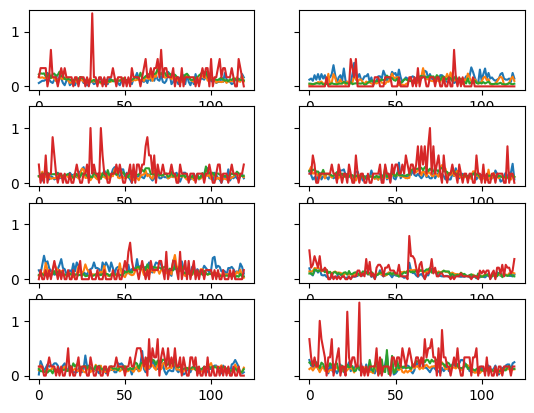

In [18]:
_, axs = plt.subplots(4, 2, sharey=True)
axs = [a for ax in axs for a in ax]
for ax, ex in zip(axs, xs.cpu()):
    ax.plot(ex.T)

In [34]:
bss, final_losses = [], []
for bs in (2 ** np.arange(6)):
    uncollated_batch = tr_dataset[:bs]
    xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
    ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)
    
    model = MLP(7, len(ROIS) * xs.shape[-1], 256, 1).to(device)
    new_optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9)

    for i in tqdm(range(10000), desc=f'Overfitting batch of size {bs}'):
        new_optimizer.zero_grad()
        logit = model(xs.flatten(1))
        loss = F.binary_cross_entropy_with_logits(logit, ys)
        loss.backward()

        gnorm = grad_norm(model)
        new_optimizer.step()

    bss.append(bs)
    final_losses.append(loss.item())

Overfitting batch of size 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 16:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 32:   0%|          | 0/10000 [00:00<?, ?it/s]

In [36]:
xs.shape

torch.Size([32, 4, 120])

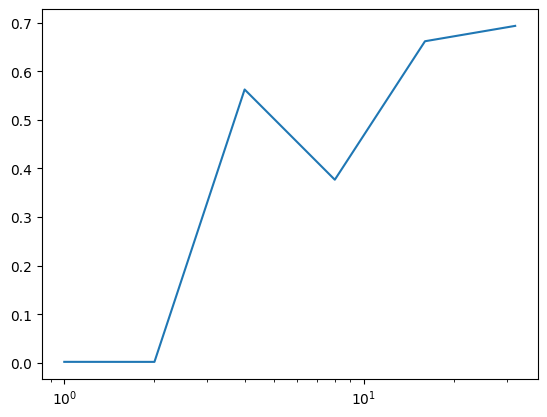

In [35]:
plt.plot(bss, final_losses)
plt.xscale('log')

In [29]:
bss, final_losses = [], []
for bs in (2 ** np.arange(6)):
    uncollated_batch = tr_dataset[:bs]
    xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
    ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)
    
    model = MovementPredictor(num_regions=len(ROIS)).to(device)
    new_optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9)

    for i in tqdm(range(10000), desc=f'Overfitting batch of size {bs}'):
        new_optimizer.zero_grad()
        logit = model(xs)
        loss = F.binary_cross_entropy_with_logits(logit, ys)
        loss.backward()

        gnorm = grad_norm(model)
        new_optimizer.step()

    bss.append(bs)
    final_losses.append(loss.item())

Overfitting batch of size 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 4:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 8:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 16:   0%|          | 0/10000 [00:00<?, ?it/s]

Overfitting batch of size 32:   0%|          | 0/10000 [00:00<?, ?it/s]

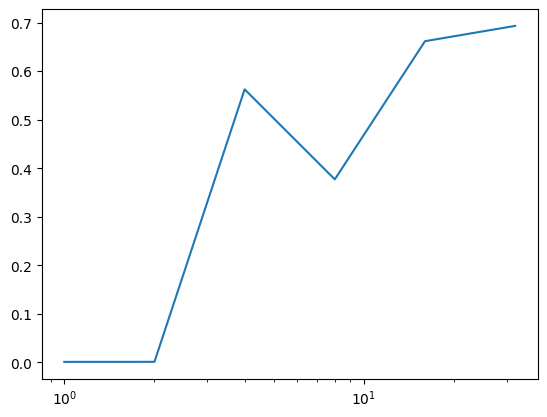

In [30]:
plt.plot(bss, final_losses)
plt.xscale('log')

In [93]:
uncollated_batch = tr_dataset[:256]
xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)

model = MovementPredictor(num_regions=len(ROIS), hidden_dim=256, num_convs=1, attn_hidden_dim=256).to(device)
new_optimizer = torch.optim.Adam(model.parameters(), 1e-4)

for i in tqdm(range(10000), desc=f'Overfitting batch of size {256}'):
    new_optimizer.zero_grad()
    logit = model(xs)
    loss = F.binary_cross_entropy_with_logits(logit, ys)
    loss.backward()

    gnorm = grad_norm(model)
    new_optimizer.step()
    
    if i % 1000 == 0:
        print(loss.item(), gnorm.item())
    
loss.item()

Overfitting batch of size 256:   0%|          | 0/10000 [00:00<?, ?it/s]

0.6931414604187012 0.005099923815578222
8.525648445356637e-05 0.00189587299246341


KeyboardInterrupt: 

In [88]:
loss

tensor(0., device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [74]:
model = MLP(15, len(ROIS) * xs.shape[-1], 512, 1).to(device)
new_optimizer = torch.optim.Adam(model.parameters(), 1e-3)

for i in tqdm(range(10000), desc=f'Overfitting batch of size {bs}'):
    new_optimizer.zero_grad()
    logit = model(xs.flatten(1))
    loss = F.binary_cross_entropy_with_logits(logit, ys)
    loss.backward()

    gnorm = grad_norm(model)
    new_optimizer.step()
    
loss.item()

Overfitting batch of size 32:   0%|          | 0/10000 [00:00<?, ?it/s]

7.078050856534901e-08

In [85]:
class SimpleConvModel(nn.Module):
    def __init__(self, tin=120, num_regions=4, n_convs=1, conv_w=25, n_hidden=256, n_mlp_layers=3):
        super().__init__()
        
        self.tin = tin
        self.num_regions = num_regions
        self.hidden_dim = n_hidden
        
        self.initial_conv = nn.Sequential(
            nn.Conv1d(1, n_hidden, conv_w, padding=conv_w // 2),
            nn.ReLU(),
        )
        
        convs = []
        for _ in range(n_convs):
            convs.append(nn.Conv1d(n_hidden, n_hidden, conv_w, padding=conv_w // 2))
            convs.append(nn.ReLU())
            
        self.convs = nn.Sequential(*convs)
        self.t_collapse = nn.Sequential(
            nn.Linear(tin * n_hidden, n_hidden),
            nn.GELU(),
        )
        self.r_collapse = nn.Sequential(
            nn.Linear(n_hidden * num_regions, n_hidden),
            nn.GELU(),
        )
        self.mlp = MLP(n_mlp_layers, n_hidden, n_hidden, 1)
        
    def forward(self, inp):
        B, N, T = inp.shape
        x = inp.view(-1, 1, T)
        x = self.initial_conv(x)
        x = self.convs(x)

        x = x.view(B, self.num_regions, self.hidden_dim * self.tin)
        x = self.t_collapse(x).view(B, -1)
        x = self.r_collapse(x)
        return self.mlp(x)

torch.Size([32, 1])